<a href="https://colab.research.google.com/github/Taketo-Muroya/Adv-ML/blob/master/Assignment_1_for_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

raw=pd.read_csv("worldhappiness2019.csv")
regiondata=pd.read_csv("region.csv")

mergedata=pd.merge(raw, regiondata, how='left', left_on='Country or region', right_on='name')

# Check for missing values (there won't be any given that I have already cleaned up the region data)
mergedata.loc[pd.isnull(mergedata).iloc[:,9]].to_csv("missing.csv",index=False)

# clean up final region data
df=mergedata.drop(['name'],axis=1)
df=df.drop(['Country or region'],axis=1)
df=df.drop(['sub-region'],axis=1)

# 
dictionary = {"Happiness_level": {"Very High": 5, "High": 4, "Average": 3, "Low": 2, "Very Low": 1}}
df.replace(dictionary, inplace=True)

df

,Happiness_level,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region
0,5,1.340,1.587,0.986,0.596,0.153,0.393,Europe
1,5,1.383,1.573,0.996,0.592,0.252,0.410,Europe
2,5,1.488,1.582,1.028,0.603,0.271,0.341,Europe
3,5,1.380,1.624,1.026,0.591,0.354,0.118,Europe
4,5,1.396,1.522,0.999,0.557,0.322,0.298,Europe
...,...,...,...,...,...,...,...,...
151,1,0.359,0.711,0.614,0.555,0.217,0.411,Africa
152,1,0.476,0.885,0.499,0.417,0.276,0.147,Africa
153,1,0.350,0.517,0.361,0.000,0.158,0.025,Asia
154,1,0.026,0.000,0.105,0.225,0.235,0.035,Africa


Text(0, 0.5, 'Healthy life expectancy')

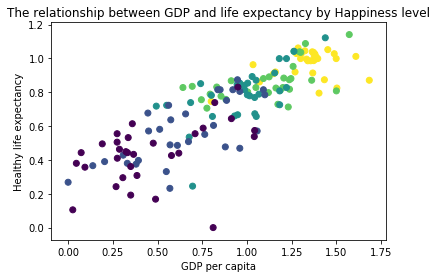

In [0]:
plt.scatter(df['GDP per capita'],df['Healthy life expectancy'],c=df['Happiness_level'])
plt.title("The relationship between GDP and life expectancy by Happiness level")
plt.xlabel("GDP per capita")
plt.ylabel("Healthy life expectancy")

In [0]:
# Set up training and test data
from sklearn.model_selection import train_test_split

y=df['Happiness_level']
X=df.drop(['Happiness_level'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_train.columns.tolist())

(117, 7)
(117,)
['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'region']


In [0]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#Fit your preprocessor object
prediction_input_preprocessor=preprocessor.fit(X_train) 

import pickle
pickle.dump(prediction_input_preprocessor, open( "preprocessor.pkl", "wb" ) )

In [0]:
y_train

26     5
134    1
79     3
131    1
36     4
      ..
71     3
106    2
14     5
92     3
102    2
Name: Happiness_level, Length: 117, dtype: int64

In [0]:
pd.get_dummies(y_train)

,1,2,3,4,5
26,0,0,0,0,1
134,1,0,0,0,0
79,0,0,1,0,0
131,1,0,0,0,0
36,0,0,0,1,0
...,...,...,...,...,...
71,0,0,1,0,0
106,0,1,0,0,0
14,0,0,0,0,1
92,0,0,1,0,0


In [0]:
a = pd.DataFrame(prediction_input_preprocessor.transform(X_train))
a.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.264057,0.202017,0.044950,0.938516,-0.100025,-0.402689,0.0,1.0,0.0,0.0,0.0
1,-0.237606,-0.195784,-2.977663,-0.525833,-1.123400,0.157965,1.0,0.0,0.0,0.0,0.0
2,0.748293,-0.122854,0.377195,0.760419,0.761231,-0.933836,0.0,0.0,1.0,0.0,0.0
3,-1.346142,-1.465432,-2.199725,-1.442699,0.133021,-0.402689,1.0,0.0,0.0,0.0,0.0
4,1.087346,0.530203,0.551420,0.945112,0.710569,-0.087936,0.0,0.0,1.0,0.0,0.0


In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200)
formodel = forest.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))

print(formodel.feature_importances_)

[0.2070085  0.16307487 0.18300199 0.13492823 0.09280472 0.13190299
 0.02417069 0.02263148 0.02291547 0.01725137 0.00030968]


In [0]:
# Set a minimum threshold of 0.1
sfm = SelectFromModel(formodel, threshold=.1)
sfm.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))
Xtrain_new = sfm.transform(prediction_input_preprocessor.transform(X_train)) # transform data to insert into new model

print(Xtrain_new[0:5,:]) #only two variables in X now

[[-0.26405736  0.20201724  0.0449503   0.93851568 -0.40268928]
 [-0.2376064  -0.19578389 -2.97766297 -0.52583263  0.15796517]
 [ 0.74829267 -0.12285368  0.37719465  0.76041927 -0.93383559]
 [-1.34614171 -1.46543247 -2.19972497 -1.44269937 -0.40268928]
 [ 1.08734577  0.53020316  0.55142035  0.94511185 -0.0879359 ]]


In [0]:
from sklearn.feature_selection import RFE

estimator = forest().fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train)) #model with all X variables
selector = RFE(estimator, 5, step=1) # step tells RFE how many features to remove each time model features are evaluated
selector = selector.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train)) # fit RFE estimator.

print("Num Features: %d") % selector.n_features_
print("Selected Features: %s") % selector.support_ # T/F for top five features
print("Feature Ranking: %s") % selector.ranking_  # ranking for top five + features

TypeError: ignored